In [4]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import newaxis
from numpy.random import seed
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore") 

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
# Read Data
data = pd.read_csv('Data/Data_March_X10_Y0.csv', index_col=0)
data.set_index('date',inplace=True)

# Transform dataframe to array
data = data.values
sequence_length = 30 + 1
result = []
for index in range(len(data) - sequence_length): #为了最后剩一个sequence长度的数据
    result.append(data[index: index + sequence_length,3])

# Normalization
# def normalise_windows(window_data):
#     normalised_data = []
#     for window in window_data:
#        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
#        normalised_data.append(normalised_window)
#    return normalised_data

#    if normalise_window:
#        result = normalise_windows(result)

result = minmax_scale(result, axis = 0)

result = np.array(result)
row = round(0.9 * result.shape[0])
train = result[:int(row), :]
np.random.shuffle(train)
x_train = train[:,1:]
y_train = train[:,0]
x_test = result[int(row):,1:]
y_test = result[int(row):,0]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

FileNotFoundError: File b'Data/Data_March_X10_Y0.csv' does not exist

> Compilation Time :  0.015217781066894531
Train on 418 samples, validate on 23 samples
Epoch 1/5
418/418 [==============================] - 2s 5ms/step - loss: 0.2448 - val_loss: 0.1416
Epoch 2/5
418/418 [==============================] - 0s 283us/step - loss: 0.1427 - val_loss: 0.0561
Epoch 3/5
418/418 [==============================] - 0s 276us/step - loss: 0.0697 - val_loss: 0.0385
Epoch 4/5
418/418 [==============================] - 0s 282us/step - loss: 0.0634 - val_loss: 0.0678
Epoch 5/5
418/418 [==============================] - 0s 290us/step - loss: 0.0788 - val_loss: 0.0312
Training duration (s) :  5.132159948348999


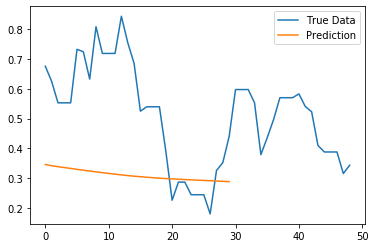

In [61]:
# Build LSTM Model
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))

    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    # sliding window
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        # rolling forecast
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])# increase the dimention
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    plt.legend()
    plt.show()

if __name__=='__main__':
    global_start_time = time.time()
    epochs  = 500
    seq_len = 30

model = build_model([1, 30, 100, 1])
model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.05)

predictions = predict_sequences_multiple(model, x_test, seq_len, 30)
print('Training duration (s) : ', time.time() - global_start_time)
plot_results_multiple(predictions, y_test, 30)

In [ ]:
# ------------Another Way------------ #

# Read Data
data = pd.read_csv('Data/Data_March_X10_Y0.csv', index_col=0)
data.set_index('date',inplace=True)

# Separate Data into Train and Test Set
train, test = train_test_split(data, test_size=0.2, random_state=888)
train = np.array(train)
test = np.array(test)

# Get Train Data
def get_train_data(batch_size=60,time_step=20):
    batch_index=[]
    data_train=train
    normalized_train_data=(data_train-np.mean(data_train,axis=0))/np.std(data_train,axis=0)  # normalization
    train_x,train_y=[],[]
    for i in range(len(normalized_train_data)-time_step):
        if i % batch_size==0:
            batch_index.append(i)
        x=normalized_train_data[i:i+time_step,1:]
        y=normalized_train_data[i:i+time_step,0,np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data)-time_step))
    return batch_index,train_x,train_y

# Get Test Data
def get_test_data(time_step=20):
    data_test=test
    mean=np.mean(data_test,axis=0)
    std=np.std(data_test,axis=0)
    normalized_test_data=(data_test-mean)/std  # normalization
    size=(len(normalized_test_data)+time_step-1)//time_step
    test_x,test_y=[],[]
    for i in range(size-1):
        x=normalized_test_data[i*time_step:(i+1)*time_step,1:]
        y=normalized_test_data[i*time_step:(i+1)*time_step,0]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(i+1)*time_step:,1:]).tolist())
    test_y.extend((normalized_test_data[(i+1)*time_step:,0]).tolist())
    return mean,std,test_x,test_y

In [ ]:
# Set Parameters
rnn_unit=10         # number of units in hidden layers 
lstm_layers=2       # number of hidden layers
lr=0.0006         # learning rate

input_size=66
output_size=1

weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
        }

biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
       }

keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [ ]:
# Define Model
def lstmCell():
    # basic LSTM unit
    basicLstm = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    # dropout
    drop = tf.nn.rnn_cell.DropoutWrapper(basicLstm, output_keep_prob=keep_prob)
    return basicLstm

def lstm(X):
    batch_size=tf.shape(X)[0]
    time_step=tf.shape(X)[1]
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  # transform tensor to 2D as the input of the next hidden layer
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  # transform tensor to 3D as the input of the lstm cell
    cell = tf.nn.rnn_cell.MultiRNNCell([lstmCell() for i in range(lstm_layers)])
    init_state=cell.zero_state(batch_size,dtype=tf.float32)
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)
    output=tf.reshape(output_rnn,[-1,rnn_unit]) 
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

def train_lstm(batch_size=60,time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size])
    batch_index,train_x,train_y=get_train_data(batch_size,time_step)
    with tf.variable_scope("sec_lstm"):
        pred,_=lstm(X) # loss function
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables(),max_to_keep=15)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(10):     # bigger, better, longer
            for step in range(len(batch_index)-1):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[batch_index[step]:batch_index[step+1]],Y:train_y[batch_index[step]:batch_index[step+1]],keep_prob:0.5})
            print("Number of iterations:",i," loss:",loss_)
        print("model_save: ",saver.save(sess,'model_save2\\modle.ckpt'))
        # run the code on windows 10,so use  'model_save2\\modle.ckpt'
        # if you run it on Linux, please use  'model_save2/modle.ckpt'
        print("The train has finished")
        
def prediction(time_step=20):
    X=tf.placeholder(tf.float32, shape=[None,time_step,input_size])
    mean,std,test_x,test_y=get_test_data(time_step)
    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):
        pred,_=lstm(X)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        # recover parameters
        module_file = tf.train.latest_checkpoint('model_save2')
        saver.restore(sess, module_file)
        test_predict=[]
        for step in range(len(test_x)-1):
          prob=sess.run(pred,feed_dict={X:[test_x[step]],keep_prob:1})
          predict=prob.reshape((-1))
          test_predict.extend(predict)
        test_y=np.array(test_y)*std[7]+mean[7]
        test_predict=np.array(test_predict)*std[7]+mean[7]
        acc=np.average(np.abs(test_predict-test_y[:len(test_predict)])/test_y[:len(test_predict)])  # deviation
        print("The accuracy of this predict:",acc)
        # show the result with line chart
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b',)
        plt.plot(list(range(len(test_y))), test_y,  color='r')
        plt.show()


train_lstm()
prediction()